# Modelo de **Hodgkin & Huxley**

Referencias:

1. https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model
2. Eugene M. Izhikevich, Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting, Computational Neuroscience, The MIT Press (2006)
3. https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/How_to_upload_an_image_to_Colab_.ipynb#scrollTo=KKTpNAGCWLeB

## **Ejercicio 1)** Importando librerías

**a)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**b)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [27]:
# 1.a)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [28]:
# 1.b)
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Ejercicio 2)** Modelo de Hodgkin y Huxley

## Teoría

### Las neuronas son capacitores

Según el modelo de Hodgkin y Huxley, a primera vista las neuronas funcionan como capacitores evidenciando una diferencia de potencial eléctrico entre el exterior y el interior debido a las diferentes concentraciones de cargas iónicas que pueden existir entre estas dos regiones.
En el esquema, se utilizan agujas muy finas para inyectar una corriente iónica $i$ al interior de una neurona sumergida en una solución salina conductora.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/esquema1.png?raw=true:, width=100" alt="My Image" width=300>

Recordemos que un capacitor sujeto a una diferencia de potencial $v:=v_A-v_B$ adquiere una carga $q=cv$.
La carga crece según $\dot{q}=i$, donde $i$ denota la corriente de carga eléctrica que va desde el exterior hacia el interior.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito1.png?raw=true:, width=100" alt="My Image" width=500>

### Las neuronas son capacitores con fugas

Si miramos un poco más en detalle, veremos que la membrana de las neuronas tienen canales por donde pueden circular iones.
Podemos pensar a los canales como agujeritos en la membrana por donde la carga se fuga.
En otras palabras, podemos pensar a los canales como a una resistencia conectada en paralelo al capacitor.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito2.png?raw=true:, width=100" alt="My Image" width=500>

La corriente $i_g=g(v_A-v_B)=gv$, donde $i_g$ denota una corriente que va desde el interior hacia el exterior.

### Las neuronas son baterias

Los canales pueden ser selectivos.
Por ejemplo, algunos canales sólo dejan pasar los iones $\mathrm{K}^+$.
Por ende, si inyectamos al interior de la neurona una mezcla de iones $\mathrm{K}^+$ y $\mathrm{Cl}^-$, de manera que la carga total se encuentre equilibrada, los iónes $\mathrm{Cl}^+$ comenzarán a difundir desde el interior hacia el exterior a travéz de los canales selectivos, mientras que los de $\mathrm{Cl}^-$ se quedarán en el interior.
Esto generará un creciente excedente de cargas negativas en el interior y positivas en el exterior, hasta alcanzar un estado de equilibrio en donde la corriente de iones $\mathrm{K}^+$ provocada por la difusión se detiene debido a la diferencia de potencial emergente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/baterias.png?raw=true:, width=100" alt="My Image" width=500>

Este potencial se llama potencial de Nernst o de reversión y se lo incorpora al circuito que modela la neurona como una batería conectada en serie a la resistencia asociada a cada canal

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito3.png?raw=true:, width=100" alt="My Image" width=500>

Ahora, la corriente $i_g=g(v_A-v_C)=g(v_A-(v_B+e_g))=g(v_A-v_B-e_g)=g(v-e_g)=:g(v-v_g)$, donde en la última iguadad reconocemos la definición del potencial de Nernst $v_g$.

Si la batería se encuentra en sentido inverso

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito4.png?raw=true:, width=100" alt="My Image" width=500>

entonces $i_g=g(v_A-v_C)=g(v_A-(v_B-e_g))=g(v_A-v_B+e_g)=g(v+e_g)=:g(v-v_g)$, por lo que el potencial de Nernst resulta negativo, $v_g=-e_g$.

### Algunos canales forman reóstatos (resistencias de conductancia variable)

Algunos canales tienen compuertas que se abren o cierran, permitiendo o impidiendo el paso de iones, respectivamente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/compuertas.png?raw=true:, width=100" alt="My Image" width=500>

La conductividad asociada a estos canales, depende de la fracción de compuertas abiertas en cada tipo de canal.
Según el modelo, la conductancia total asociada a los canales de $\mathrm{Na}$ se aproxima por

$$g_{\mathrm{Na}} = \bar{g}_{\mathrm{Na}}p_{\mathrm{Na}}$$

donde $\bar{g}_{\mathrm{Na}}$ es la conductancia de $\mathrm{Na}$ máxima posible y

$$p_{\mathrm{Na}} = m^3h$$

es la fracción de canales de $\mathrm{Na}$ abiertos.
Aquí $m$ y $h$ son la fracciones de compuertas abiertas de activación e inactivación, respectivamente.
Los canales de $\mathrm{Na}$ poseen 3 compuertas de activación y 1 de inactivación, por lo que $m$ tiene un exponente 3 y $h$ un exponente 1.

De manera similar, la conductancia asociada a los canales de $\mathrm{K}$ se aproxima por

$$g_{\mathrm{K}} = \bar{g}_{\mathrm{K}}p_{\mathrm{K}}$$

donde $\bar{g}_{\mathrm{K}}$ es la conductancia de $\mathrm{K}$ máxima posible,

$$p_{\mathrm{K}} = n^4$$

es la fracción de canales de $\mathrm{K}$ abiertos y $n$ es la fracción de compuertas abiertas en este tipo de canales.
Cada canal de $\mathrm{K}$ posee 4 compuertas de tipo $n$, de ahí el exponente 4.

Estas aproximaciones asumen que las compuertas abren o cierran de manera independiente, dependiendo de la diferencia de potencial de membrana existente $v$.
Más precisamente, las fracciones de compuertas abiertas de cada tipo satisfacen

\begin{align}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h
\end{align}

donde

\begin{align}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{align}

representan las tasas a las cuales las compuertas cerradas de cada tipo abren y

\begin{align}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{align}

representan las tasas a las cuales las compuertas abiertas de cada tipo cierran, respectivamente.

En resumen, al modelo de neurona de Hodgkin y Huxley se lo puede representar por el circuito

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito5.png?raw=true:, width=100" alt="My Image" width=500>

en donde reconocemos la existencia de 3 canales iónicos: uno de pérdida (leak) de conductancia constante $g_l$, potencial de Nernst $v_l=e_l$ y por el que fluye una corriente $i_l$, uno de $\mathrm{Na}$ de conductancia variable $g_{\mathrm{Na}}$, potencial de Nernst $v_{\mathrm{Na}}=e_{\mathrm{Na}}$ y por el que fluye una corriente $i_{\mathrm{Na}}$, y uno de $\mathrm{K}$ de conductancia $g_{\mathrm{K}}$, potencial de Nernst $v_{\mathrm{K}}=-e_{\mathrm{K}}$ y por el que fluye una corriente $i_{\mathrm{K}}$.

Aplicando la ley de Kirchoff para corrientes, vemos que

$$i=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l+i_c$$

Es decir, la corriente $i$ inyectada al interior de la neurona se divide en dos partes.
Por un lado, en la corriente $i_m=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l$ que fluye a travéz de los canales en la membrana,
y por otro lado, en la corriente $i_c$ que carga el capacitor.

Remplazando, obtenemos una ODE para el potencial de membrana

\begin{align}
i_c&=&i-i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l\\
c\dot{v}&=&i-g_{\mathrm{Na}}(v-v_{\mathrm{Na}})-g_{\mathrm{K}}(v-v_{\mathrm{K}})-g_{l}(v-v_{l})\\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{align}

La última línea de la anterior ecuación, junto con las ODEs anteriormente mencionadas para $n$, $m$ y $h$, determinan el sistema de ODEs del modelo de Hodgkin y Huxley.

### Comportamiento cualitativo

Durante el proceso de disparo, diferentes compuertas se abren y cierran a diferentes tiempos.
El siguiente esquema resume el proceso en 4 etapas

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/channels.png?raw=true:, width=100" alt="My Image" width=300>

Estimaciones de los tiempos carácterísticos y valores de equilibrio del comportamiento de las compuertas observado en las diferentes etapas se pueden obtener de reescribir las ODEs para $n$, $m$ y $h$ de la forma

\begin{align}
\dot{n}&=&\tau_n^{-1}(v)(n_{\infty}(v)-n)\\
\dot{m}&=&\tau_m^{-1}(v)(m_{\infty}(v)-m)\\
\dot{h}&=&\tau_h^{-1}(v)(h_{\infty}(v)-h)
\end{align}

donde

\begin{align}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{align}

y

\begin{align}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{align}

Finalmente, listamos los valores de los parámetros del modelo (ver libro de Izhikevich)

* $c=1\,\mu F/cm^2$ : capacitancia de membrana
* $\bar{g}_{\mathrm{Na}}=120\,mS/cm^2$ : conductancia máxima de $\mathrm{Na}$
* $\bar{g}_{\mathrm{K}}=36\,mS/cm^2$ : conductancia máxima de $\mathrm{K}$
* $g_l=0.3\,mS/cm^2$ : conductancia máxima de perdida
* $v_{\mathrm{Na}}=120\,mV$ : potencial de reversión de la corriente de $\mathrm{Na}$
* $v_{\mathrm{K}}=-12\,mV$ : potencial de reversión de la corriente de $\mathrm{K}$
* $v_l=10.6\,mV$ : potencial de reversión de la corriente de perdida
* $i(t)\sim 10\,\mu A/cm^2$ : corriente de entrada al tiempo $t$
* $t \sim 5\,ms$ : tiempo

Aclaración, los valores de los potenciales de Nernst se toman en referencia al potencial de equilibrio definido en $v\approx 0\, mV$.

## Ejercicio 2) implementación

**1)** Usando la sección de teoría y las referencias, implemente el modelo de Hodgkin y Huxley el integrador numérico de ODEs tipo Runge-Kutta de orden 4 del práctico 4.

**2)** Grafique los valores de equilibrio de las distintas fracciones de canales activados $n_{\infty}$, $m_{\infty}$ e inactivados $h_{\infty}$, en función de la diferencia de potencial de membrana $v$.

**3)** Grafique los tiempos característicos de activación $\tau_m$, $\tau_n$ e inactivación $\tau_h$ asociados a los distintos tipos de canales, en función de la diferencia de potencial de membrana $v$.

Las ecuaciones diferenciales que representan mi sistema son:

$$
\begin{align}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h \\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{align}
$$

Donde:
$$
\begin{align}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{align}
$$
$$
\begin{align}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{align}
$$

$$
\begin{align}
\dot{n}&=&\tau_n^{-1}(v)(n_{\infty}(v)-n)\\
\dot{m}&=&\tau_m^{-1}(v)(m_{\infty}(v)-m)\\
\dot{h}&=&\tau_h^{-1}(v)(h_{\infty}(v)-h) \\

\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1} \\

n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)\\
\end{align}
$$

In [29]:
# defino las funciones necesarias
def alpha_n (v): 
    # v = potencial de membrana
    return ((10 - v)/(np.exp((10-v)/10)-1))*0.01
def alpha_m (v):
    # v = potencial de membrana
    return ((25 - v)/(np.exp((25-v)/10)-1))*0.1
def alpha_h (v):
    # v = potencial de membrana
    return 0.07*np.exp(-v/20)

def beta_n (v):
    # v = potencial de membrana
    return 0.125*np.exp(-v/80)
def beta_m (v):
    # v = potencial de membrana
    return 4*np.exp(-v/18)
def beta_h (v):
    # v = potencial de membrana
    return 1/(np.exp((30-v)/10)+1)

In [30]:
def tau_n(v):
    return 1/(alpha_n(v)+beta_n(v))
def tau_m(v):
    return 1/(alpha_m(v)+beta_m(v))
def tau_h(v):
    return 1/(alpha_h(v)+beta_h(v))

def n_inf(v):
    return tau_n(v)*alpha_n(v)
def m_inf(v):
    return tau_m(v)*alpha_m(v)
def h_inf(v):
    return tau_h(v)*alpha_h(v)

$$
\begin{align}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h \\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{align}
$$

* $c=1\,\mu F/cm^2$ : capacitancia de membrana
* $\bar{g}_{\mathrm{Na}}=120\,mS/cm^2$ : conductancia máxima de $\mathrm{Na}$
* $\bar{g}_{\mathrm{K}}=36\,mS/cm^2$ : conductancia máxima de $\mathrm{K}$
* $g_l=0.3\,mS/cm^2$ : conductancia máxima de perdida
* $v_{\mathrm{Na}}=120\,mV$ : potencial de reversión de la corriente de $\mathrm{Na}$
* $v_{\mathrm{K}}=-12\,mV$ : potencial de reversión de la corriente de $\mathrm{K}$
* $v_l=10.6\,mV$ : potencial de reversión de la corriente de perdida
* $i(t)\sim 10\,\mu A/cm^2$ : corriente de entrada al tiempo $t$
* $t \sim 5\,ms$ : tiempo

In [31]:
# defino mi funcion f para el modelo de Hodgkin-Huxley para utilizar en el integrador de ode
def n_dot(x,t,p):
    v = x[3]
    return (n_inf(v)-x[0])/tau_n(v)
def m_dot(x,t,p):
    v = x[3]
    return (m_inf(v)-x[1])/tau_m(v)
def h_dot(x,t,p):
    v = x[3]
    return (h_inf(v)-x[2])/tau_h(v)
def v_dot(x,t,p):
    n = x[0]
    m = x[1]
    h = x[2]
    v = x[3]
    c = p[0]
    g_Na = p[1]
    g_k = p[2]
    g_l = p[3]
    v_Na = p[4]
    v_k = p[5]
    v_l = p[6]
    i = p[7]
    return (i(t) - g_Na*(m**3)*h*(v-v_Na) - g_k*(n**4)*(v-v_k) - g_l*(v-v_l))/c

def int_HyH(x, t, p):
    return np.array([n_dot(x,t,p),m_dot(x,t,p),h_dot(x,t,p),v_dot(x,t,p)])

Resuelvo el sistema de ecuaciones con Runge-Kutta de orden 4.

In [32]:
# Defino los parametros

## Ejercicio 3) valores de equilibrio

**1)** Integre el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a una corriente total $i(t)=0$ para todo $t$. Use la condición inicial $v_0=0mV$, $n_0=m_0=h_0=0$ y $t_0=0ms$. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

In [33]:
# 3.1)
c = 1
g_Na = 120
g_k = 36
g_l = 0.3
v_Na = 120
v_k = -12
v_l = 10.6
i = lambda t: 0
p = [c,g_Na,g_k,g_l,v_Na,v_k,v_l,i]

x0 = [0,0,0,0]
t0 = 0
tf = 500
h = 0.01
k = int((tf-t0)/h)

In [34]:
t,w = integrador_ode(rk4,int_HyH,x0,t0,tf,k,p)
v_rk = w[3,:]
n_rk = w[0,:]
m_rk = w[1,:]
h_rk = w[2,:]

**2)** Grafique el potencial de membrana en función del tiempo, i.e. grafique $v(t)$ vs $t$ en el rango calculado.

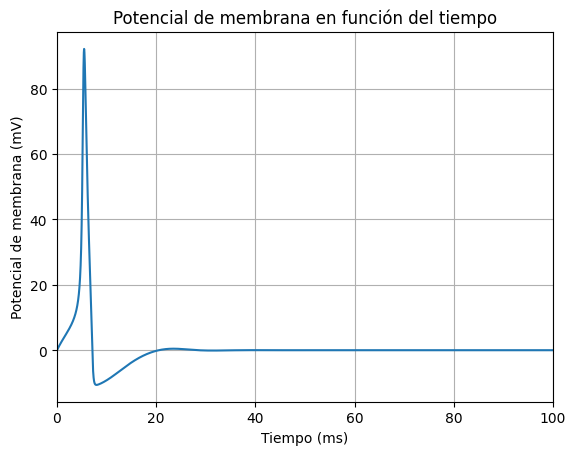

In [35]:
# 3.2)
plt.plot(t,v_rk)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title('Potencial de membrana en función del tiempo')
plt.xlim(0,100)
plt.grid()
plt.show()


**3)** Grafique las diferentes corrientes de iones cruzando la membrana en función del tiempo, i.e. grafique  la corriente de iones de sodio $i_{Na}(t)$, la corriente de iones de potasio $i_K(t)$ y la corriente de pérdida $i_l(t)$ vs $t$ en el rango calculado.

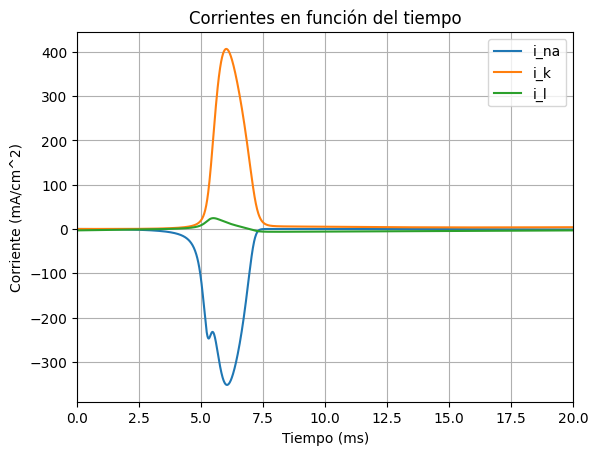

In [36]:
# 3.3) graficar i_na, i_k, i_l en función del tiempo
i_na = g_Na*(m_rk**3)*h_rk*(v_rk-v_Na)
i_k = g_k*(n_rk**4)*(v_rk-v_k)
i_l = g_l*(v_rk-v_l)

plt.plot(t,i_na,label='i_na')
plt.plot(t,i_k,label='i_k')
plt.plot(t,i_l,label='i_l')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Corriente (mA/cm^2)')
plt.title('Corrientes en función del tiempo')
plt.xlim(0,20)
plt.legend()
plt.grid()
plt.show()

**4)** Grafique las fracción de canales activados e inactivados de cada tipo en función del tiempo, i.e. grafique $n(t)$ (fracción de canales de potasio $K$ activos), $m(t)$ (fracción de canales de sodio $Na$ activos) y $h(t)$ (fracción de canales de sodio $Na$ inactivos) vs $t$ en el rango calculado.

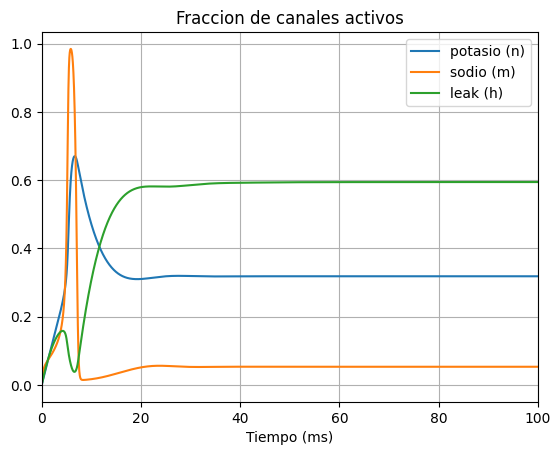

In [37]:
# 3.4) graficar n, m, h en función del tiempo
plt.plot(t,n_rk,label='potasio (n)')
plt.plot(t,m_rk,label='sodio (m)')
plt.plot(t,h_rk,label='leak (h)')
plt.xlabel('Tiempo (ms)')

plt.title('Fraccion de canales activos')
plt.xlim(0,100)
plt.legend()
plt.grid()
plt.show()

**5)** Almacene los valores de equilibrio a corriente nula de las variables dinámicas usando los valores de las mismas obtenidos a tiempos largos. Es decir, almacene los valores $v^* \approx v(t_f)$, $n^* \approx n(t_f)$, $m^* \approx m(t_f)$ y $h^* \approx h(t_f)$, para ser utilizado como condiciones iniciales en futuras integraciones de las ODEs del modelo de Hodgkin y Huxley.

In [38]:
# 3.5)
v_eq = v_rk[-1]
n_eq = n_rk[-1]
m_eq = m_rk[-1]
h_eq = h_rk[-1]

## Ejercicio 4) estímulo débil y estímulo fuerte

**1)** Implemente una función de corriente de entrada o membrana dada por:

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [2ms,2.5ms] \\
30 \mu A/cm^2, & t\in [10ms,10.5ms] \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Aquí, $c.c.$ indica *en caso contrario*. Esta corriente representa un estímulo débil seguido de uno fuerte. Grafíque la corriente $i(t)$ vs $t$ en el rango $t\in[0ms,20ms]$.

In [39]:
# 4.1)
def i_ej4(t):
    if 2.0 <= t <= 2.5:
        return 10
    elif 10.0 <= t <= 10.5:
        return 30
    else:
        return 0

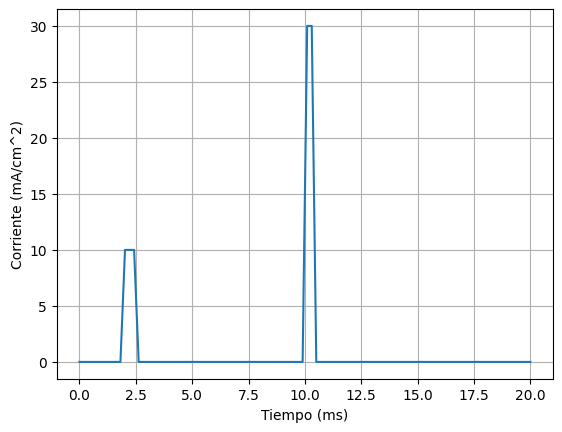

In [40]:
t = np.linspace(0,20,100)
plt.plot(t,[i_ej4(i) for i in t])
plt.xlabel('Tiempo (ms)')
plt.ylabel('Corriente (mA/cm^2)')
plt.grid()
plt.show()


**2)** Integre nuevamente el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a la corriente del inciso anterior. Use como condición inicial a tiempo $t=0$ los valores de equilibrio estimados en el ejercicio anterior. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

In [42]:
c = 1
g_Na = 120
g_k = 36
g_l = 0.3
v_Na = 120
v_k = -12
v_l = 10.6
i = i_ej4
p = [c,g_Na,g_k,g_l,v_Na,v_k,v_l,i]

x0 = [n_eq,m_eq,h_eq,v_eq]
t0 = 0
tf = 500
h = 0.01
k = int((tf-t0)/h)

In [43]:
t_2,w_2 = integrador_ode(rk4,int_HyH,x0,t0,tf,k,p)
n_2 = w_2[0,:]
m_2 = w_2[1,:]
h_2 = w_2[2,:]
v_2 = w_2[3,:]

**3)** Grafique el potencial de membrana en función del tiempo, i.e. $v(t)$ vs $t$ en el rango calculado.

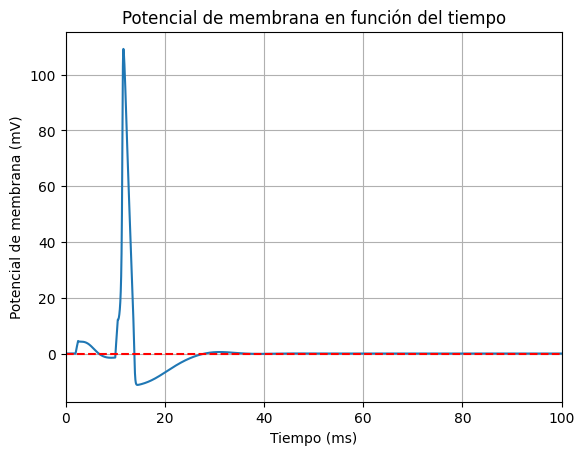

In [54]:
plt.plot(t_2,v_2)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de membrana (mV)')
plt.title('Potencial de membrana en función del tiempo')
plt.axhline(y=v_eq, color='r', linestyle='--', label='v_eq')
plt.xlim(0,100)
plt.grid()
plt.show()

**4)** Grafique la evolución de las fraciones de canales activos e inactivos, $n(t)$, $m(t)$ y $h(t)$ vs $t$.

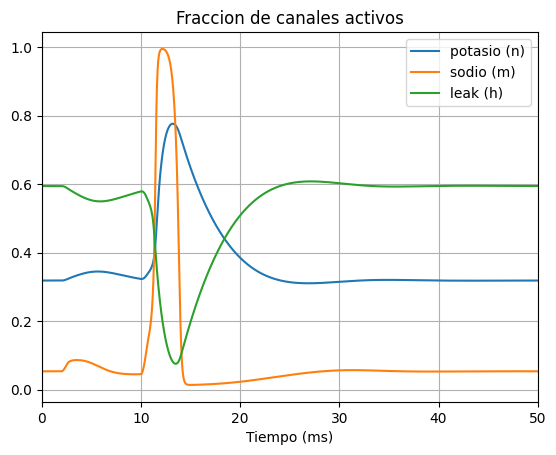

In [57]:
plt.plot(t_2,n_2,label='potasio (n)')
plt.plot(t_2,m_2,label='sodio (m)')
plt.plot(t_2,h_2,label='leak (h)')
plt.xlabel('Tiempo (ms)')
plt.title('Fraccion de canales activos')
plt.xlim(0,50)
plt.legend()
plt.grid()
plt.show()

**5)** Discuta como responde la neurona en el primer impulso a $t=2ms$. Luego, como responde al segundo impulso a $t=10ms$. Existe una diferencia? Explique.

TODO

## Ejercicio 5) ráfaga

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [5ms,\infty ms) \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Esta corriente representa un estímulo constante.

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando como condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [14]:
# 5.1)

## Ejercicio 6) período refractario

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [10ms\, k,10 ms\, k + 2ms], k \in \{1,2,3,4,5,...\}\\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando la corriente del inciso **12)**, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [15]:
# 6.1)

## Ejercicio 7) exitaciones espontáneas en respuesta al ruido

**1)** Implemente una corriente estocástica que retorne un valor $i(t)\sim i_0 N(0,1)$ (i.e. $i_0$ por un valor aleatorio obtenido de una distribución normal de media 0 y varianza 1) para cada valor de $t$ en el que sea evaluada.

**2)** Integre nuevamente las ODEs para $t\in[0ms,500ms]$, usando la corriente del inciso **22)** para $i_0=50\mu A$, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Observa picos de activación cada tanto? Aparecen con regularidad? Estime con que frecuencia observa los picos.

In [16]:
# 7.1)